In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/workspaces/twoohfoureight/src")

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from IPython import display
import time

In [5]:
import ipywidgets as widgets

In [2492]:
import game.rules as rules
from game.rules import (UP, LEFT, DOWN, RIGHT)
import game.multi as multi
import game.strategies as strategies
import game.display as game_display

## Baseline random strategies

First, we'll try some random strategies to get a baseline for performance on the 2048 game.  It's typically a good strategy in 2048 to 'break symmetry', and as much as possible, make moves that favour moving towards one corner.  These strategies favour moving DOWN and LEFT, and we play 100 games to completion (i.e. until there are no valid remaining moves) with each.

In [35]:
choice_strategies = [
    [DOWN, LEFT] * 30 + [RIGHT]*1 + [UP],
    [DOWN, LEFT] * 30 + [RIGHT]*3 + [UP],    
    [DOWN, LEFT] * 30 + [RIGHT]*10 + [UP],
    [DOWN, LEFT] * 30 + [RIGHT]*30 + [UP],
]

n_games = 500
progress_bar = widgets.FloatProgress(max=n_games)
def update_progress_bar(n_game): progress_bar.value = n_game+1

display.display(progress_bar)
    
result = [
    rules.play_to_completion(strategies.random_strategy(vec), n_games, progress_callback=update_progress_bar)
    for vec in choice_strategies
]

FloatProgress(value=0.0, max=500.0)

KeyboardInterrupt: 

The following histograms show the distribution of the highest scoring cell across the 500 games for each strategy. The best performing strategy appears to be the first, with DOWN and LEFT moves outnumbering RIGHT and UP moves by 30 to 1, but there's not much in it. None of these baseline strategies are able to get a $2^{10} =  1024$ cell.

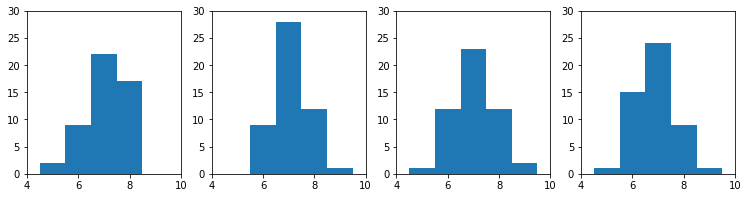

In [7]:
plt.figure(figsize=(16,3))
for ind, x in enumerate(result):
    plt.subplot(151+ind, xlim=(4,10), ylim=(0,30))
    plt.hist([score for mvs, score in x], bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.show()

In the interest of speeding up the evaluation of a strategy, the `game.multi` package takes advantage of numpy vectorisation to play multiple games 'at once'. The 'multi' game state with $n$ games is represented by an $n \times 4 \times 4$ numpy array.

In [40]:
def random_strategy_multi(choices):
    def strategy(state):
        return np.random.choice(choices, size=state.shape[0])
    return strategy

In [43]:
n_games = 2000
progress_bar = widgets.FloatProgress(max=n_games)

def update_progress_bar(n_complete): progress_bar.value = n_complete+1

display.display(progress_bar)

move_counts, complete, final_states = multi.play_to_completion(
    random_strategy_multi(choice_strategies[0]), n_games, max_turns=10000,
    progress_callback=update_progress_bar
)

FloatProgress(value=0.0, max=2000.0)

all games complete after 1709 turns


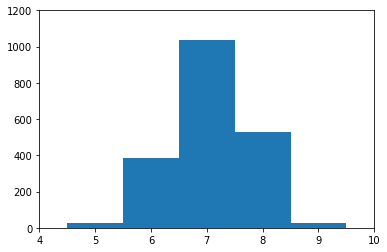

In [44]:
plt.subplot(111, xlim=(4,10), ylim=(0,1200))
plt.hist(np.max(final_states.reshape(2000, -1), axis=1), bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.show()

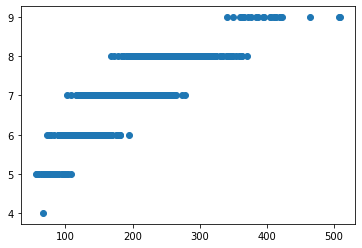

In [45]:
plt.scatter(move_counts, np.max(final_states.reshape(2000, -1), axis=1))

## Trying to do better with reinforcement learning

In [1663]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from operator import itemgetter

We'll use a very simple 2 layer network to start with:

- one-hot encoding for the game board
- feeding into a $4 \times 4 \times 8$ convolutional layer, with $2 \times 2$ kernel and relu activation
- feeding into a $96$ unit dense layer, also relu
- feeding into a $4$ unit output layer, where each output unit represents one of the possible moves (UP, LEFT, DOWN, RIGHT)

In [2552]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (2, 2), padding="valid", activation="relu", input_shape=(4,4,12)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu")
])
sgd = tf.keras.optimizers.SGD(lr=1e-4)
model.compile(loss="mse", optimizer=sgd)

In [2553]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 3, 8)           392       
_________________________________________________________________
flatten_22 (Flatten)         (None, 72)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 96)                7008      
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 388       
Total params: 7,788
Trainable params: 7,788
Non-trainable params: 0
_________________________________________________________________


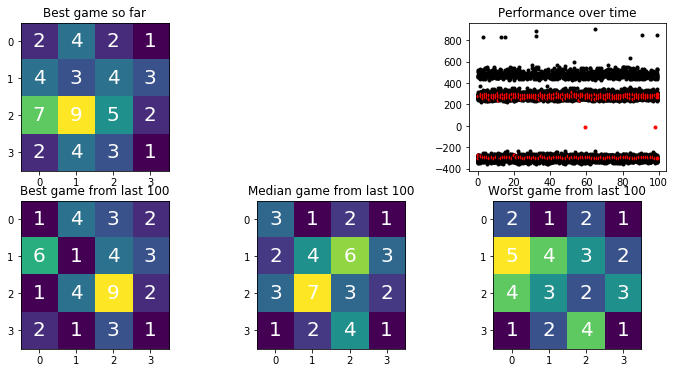

Episode 99 of 100: 845.0, 900.0, 334, 0.4587773745967664


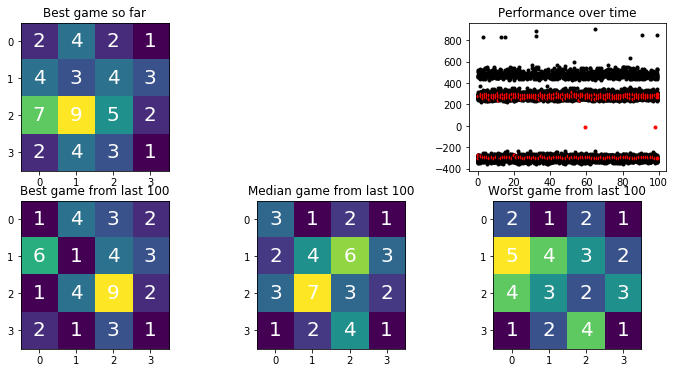

In [2554]:
e = 0.5 # ε for ε-greedy policy
y = 0.999 # Temporal discount factor
num_episodes = 100
n_games = 100

rng = np.random.default_rng()

def reward_on_completion_fn(state):
    """Reward function for final state in a completed game:
    
    - If the agent does not make at least one 7 square, it's punished by 400 points
    - Otherwise, it earns 2^n where n is the largest value square on the board.
    """
    max_square = np.max(state, axis=(1,2))
    return np.where(max_square >= 7, 2.0**max_square, -400)

init_state, select_action, act = multi.env(n_games, reward_on_completion_fn)

fig = plt.figure(figsize=(12,6))
overall_best_plot = fig.add_subplot(2,3,1)
trend_plot = fig.add_subplot(2,3,3)
current_best_plot = fig.add_subplot(2,3,4)
current_med_plot = fig.add_subplot(2,3,5)
current_worst_plot = fig.add_subplot(2,3,6)

top_state = None
top_reward = 0
for episode in range(num_episodes):
    state = init_state()
    total_reward = np.zeros(n_games)
    live = np.full(n_games, True)
    
    move_counts = np.zeros(n_games)
    
    move = 0
    
    while move < 2000:
        move += 1
        n_live = np.sum(live)
        
        # Get the model estimate of the expected reward based on the current state
        R_current = model.predict(to_categorical(state[live], 12))
        
        # Use an ε-greedy policy for action selection
        is_random = rng.choice([True, False], p=[e, 1-e], size=(n_live, 1))
        actions = select_action(
            state[live],
            np.where(is_random, np.random.rand(n_live, 4), R_current)
        )

        updated_state, rewards, became_complete, now_live = act(state, actions, live)
        
        # Update the model
        R_new = model.predict(to_categorical(updated_state[live], 12))
        target = rewards[live] + y * np.max(R_new, axis=1)
        R_target = np.array(R_current)
        R_target[:, actions] = target
        model.fit(to_categorical(state[live], 12), R_target, epochs=1, verbose=0)
        
        total_reward += rewards
        
        state = updated_state
        
        move_counts += live
        live = now_live
    
        # Reduce e and terminate if all done
        if np.all(~live):
            if np.max(total_reward) > 500:
                e *= 0.999
                e = e if e > 0.1 else 0.1
            break

    # show some figures
    best_game = np.argmax(total_reward)
    max_reward = np.max(total_reward)
    top_state = state[best_game, :, :] if max_reward > top_reward else top_state
    top_reward = max_reward if max_reward > top_reward else top_reward
    display.clear_output(wait=True)
    
    overall_best_plot.cla()
    game_display.show_state(overall_best_plot, top_state)
    overall_best_plot.set_title("Best game so far")

    trend_plot.plot(np.full(total_reward.shape, episode), total_reward, 'k.')
    r_perc = np.percentile(total_reward, np.array([25, 50, 75]))
    trend_plot.plot(np.full(r_perc.shape, episode), r_perc, 'r.')
    trend_plot.set_title("Performance over time")
    
    current_best_plot.cla()
    best_game_state = state[best_game, :, :]
    game_display.show_state(current_best_plot, state[best_game, :, :])
    current_best_plot.set_title(f"Best game from last {n_games}")
    
    current_med_plot.cla()
    med_game_ind = np.argsort(total_reward)[len(total_reward)//2]
    game_display.show_state(current_med_plot, state[med_game_ind, :, :])
    current_med_plot.set_title(f"Median game from last {n_games}")
    
    current_worst_plot.cla()
    worst_game_state = state[np.argmin(total_reward), :, :]
    game_display.show_state(current_worst_plot, worst_game_state)
    current_worst_plot.set_title(f"Worst game from last {n_games}")
    
    display.display(fig)
    status = f"Episode {episode} of {num_episodes}: {max_reward}, {top_reward}, {move}, {e}"
    print(status)    

It doesn't look like the agent is learning in this configuration. The median and quartiles don't change over time. Would be interesting to understand how to diagnose what's going on.  Are the gradients too small? Too noisy? What is the learning signal? Does this approach work with a simpler game? Is the problem with the architecture of the network, or the parameters in the training regime (i.e. temporal discount rate; $\epsilon$; the schedule for decreasing $\epsilon$; the number of training epochs per game turn; the learning rate; ...)

I'll extract the various hyperparameters out, and put all of the training logic into a function to explore more systematically.